# Optimización Bayesiana

## Introducción

En el ámbito de la ciencia de datos y el aprendizaje automático, la selección de hiperparámetros desempeña un papel crucial para garantizar el desempeño óptimo de los modelos predictivos. Los hiperparámetros, a diferencia de los parámetros internos de un modelo, son configuraciones que deben definirse antes del proceso de entrenamiento y que afectan directamente la capacidad del modelo para generalizar, es decir, aprender patrones complejos y evitar problemas como el sobreajuste o el subajuste. 
Tradicionalmente, las técnicas como la búsqueda en cuadrícula (Grid Search) o la búsqueda aleatoria (Random Search) han sido ampliamente utilizadas para esta tarea. Sin embargo, su naturaleza exhaustiva o aleatoria las hace poco eficientes, especialmente en escenarios donde el espacio de búsqueda es vasto o los recursos computacionales son limitados.

La optimización bayesiana ha emergido como una metodología eficiente y efectiva para abordar el problema de la selección de hiperparámetros. Esta técnica combina principios probabilísticos y de optimización para modelar de manera iterativa el espacio de búsqueda, utilizando un enfoque basado en la exploración y explotación de las configuraciones más prometedoras. Al construir un modelo probabilístico del rendimiento del modelo en función de los hiperparámetros, la optimización bayesiana permite identificar de manera más estratégica aquellos conjuntos de hiperparámetros que maximizan o minimizan una métrica objetivo, como la pérdida logarítmica, la exactitud o cualquier otra medida de desempeño.

Este proyecto se enfoca en explorar la aplicación de la optimización bayesiana para la búsqueda de hiperparámetros en modelos de aprendizaje automático. A través de una combinación de métodos numéricos, técnicas de optimización y herramientas avanzadas como Gaussian Processes, Tree-structured Parzen Estimators (TPE) o modelos basados en redes neuronales, se busca evaluar cómo esta técnica mejora la eficiencia y el rendimiento en comparación con enfoques tradicionales. Además, se analizarán los beneficios, desafíos y limitaciones inherentes a su implementación, proporcionando un marco de referencia para la selección óptima de hiperparámetros en proyectos de machine learning y deep learning.

## Optimización Bayesiana en la literatura
El hallazgo de hiperparámetros adecuados es crucial para mejorar el rendimiento y la generalización de los modelos de aprendizaje automático. Existen varios métodos descritos en la literatura moderna que pueden ayudar a encontrar los hiperparámetros que mejor se ajustan. El rendimiento se prueba en diferentes conjuntos de datos que se prueban y se estudian bien, como MINST. Los hiperparámetros (HP) son externos al proceso de aprendizaje, pero afectan significativamente el rendimiento del modelo. Los HP son externos al proceso de aprendizaje, pero afectan significativamente el rendimiento del modelo. Un ajuste efectivo generalmente requiere experiencia en el dominio o métodos computacionalmente costosos como la búsqueda de fuerza bruta. Un ajuste efectivo generalmente requiere experiencia en el dominio o métodos computacionalmente costosos como la búsqueda de fuerza bruta En [1, 2, 3], se explora la optimización bayesiana. La optimización bayesiana aprovecha el conocimiento previo para actualizar las distribuciones posteriores en función de los datos de muestra, lo que guía la búsqueda de configuraciones óptimas de hiperparámetros de manera eficiente. Los enfoques tradicionales como la búsqueda en cuadrícula y la búsqueda aleatoria son computacionalmente costosos y menos efectivos en espacios de alta dimensión. La optimización bayesiana ofrece una alternativa más eficiente, particularmente para funciones objetivo de caja negra costosas. 

En [1] se explora el uso de la optimización bayesiana para ajustar los hiperparámetros en los modelos de aprendizaje automático, lo que es fundamental para mejorar el rendimiento del modelo. El estudio propone un método que utiliza la optimización bayesiana con procesos gaussianos. Los enfoques tradicionales, como la búsqueda en cuadrícula y la búsqueda aleatoria, son computacionalmente costosos y menos efectivos en espacios de alta dimensión. La optimización bayesiana ofrece una alternativa más eficiente, particularmente para funciones objetivo de caja negra costosas. Los resultados se realizaron en modelos de aprendizaje automático como bosques aleatorios, redes neuronales (CNN y RNN) y bosques profundos (gcForest). La optimización bayesiana demostró mejoras significativas en la precisión de la predicción y la eficiencia computacional en comparación con los métodos tradicionales. Los resultados confirman que la optimización bayesiana supera a otras técnicas de optimización en términos de velocidad y logro de un mejor rendimiento del modelo, especialmente en escenarios con recursos computacionales limitados o espacios de hiperparámetros de alta dimensión.

En [2] se afirma que los modelos complejos como las redes de creencias profundas (DBN) tienen numerosos hiperparámetros, lo que hace que la optimización manual sea ineficiente e inconsistente. La dificultad para ajustar estos modelos obstaculiza la reproducibilidad y el progreso en la investigación del aprendizaje automático. Por lo tanto, los enfoques propuestos se basan en la Búsqueda aleatoria, un método en el que los hiperparámetros se muestrean aleatoriamente a partir de distribuciones predefinidas. Es eficiente para problemas simples, pero tiene dificultades con modelos complejos como las DBN. Para mejorar esta desventaja, se presenta la Optimización basada en modelos secuenciales. Este método aproxima la función de pérdida con un modelo sustituto para guiar la búsqueda. Se explican dos variantes específicas de los métodos: el proceso gaussiano y el estimador Parzen estructurado en árbol. Ambos métodos se probaron en DBN con hasta 32 hiperparámetros en tareas como la clasificación de imágenes en conjuntos de datos como MNIST y MRBI. Los resultados muestran que la búsqueda aleatoria coincidió con la optimización manual humana para tareas simples, pero falló para conjuntos de datos más difíciles. El estimador Parzen estructurado en árbol superó consistentemente tanto la búsqueda aleatoria como el ajuste manual, logrando una mejor precisión y eficiencia. El proceso gaussiano fue efectivo pero menos eficiente que el TPE debido a la sobrecarga computacional.

En [3], los resultados demuestran que se realizaron experimentos en modelos de aprendizaje automático como bosques aleatorios, redes neuronales (CNN y RNN) y bosques profundos (gcForest). La optimización bayesiana demostró mejoras significativas en la precisión de la predicción y la eficiencia computacional en comparación con los métodos tradicionales. Los resultados confirman que la optimización bayesiana supera a otras técnicas de optimización en términos de velocidad y logro de un mejor rendimiento del modelo, especialmente en escenarios con recursos computacionales limitados o espacios de hiperparámetros de alta dimensión.

## Optimización de Hiperparámetros

En la práctica, es necesario ajustar continuamente los hiperparámetros y entrenar una serie de modelos con diferentes combinaciones de valores, y luego comparar el rendimiento del modelo para elegir el mejor modelo. Por lo tanto, cómo optimizar los hiperparámetros se convierte en una cuestión clave en un algoritmo de aprendizaje automático.

Existen principalmente dos tipos de métodos de optimización de hiperparámetros: la búsqueda manual y los métodos de búsqueda automática.
La búsqueda manual prueba los conjuntos de hiperparámetros manualmente. Depende de la intuición fundamentalmente y la experiencia de los usuarios para identificar los parámetros importantes que tienen un mayor impacto en los resultados y luego determinar la relación entre ciertos parámetros y los resultados finales a través de las herramientas de visualización.

El proceso de ajuste de hiperparámetros no es fácil de reproducir. Además, a medida que aumenta la cantidad de hiperparámetros y el rango de valores, se vuelve bastante difícil de gestionar, ya que los humanos no son buenos en el manejo de datos de alta dimensión y malinterpretan o pasan por alto fácilmente las tendencias y relaciones en los hiperparámetros.

Para superar los inconvenientes de la búsqueda manual, se han propuesto algoritmos de búsqueda automática, como la búsqueda en cuadrícula o la búsqueda cartesiana de hiperparámetros (`GridSearch`). 

El principio del `GridSearch` es una búsqueda exhaustiva, este entrena un modelo de aprendizaje automático con cada combinación de posibles valores de hiperparámetros en el conjunto de entrenamiento y evalúa el rendimiento, de acuerdo con una métrica predefinida en un conjunto de validación cruzada. Finalmente, genera hiperparámetros que logran el mejor rendimiento. 
Aunque este método logra un ajuste automático y teóricamente puede obtener el valor óptimo global de la función objetivo de optimización, sufre la maldición de la dimensionalidad, es decir, la eficiencia del algoritmo disminuye rápidamente a medida que aumenta el número de hiperparámetros que se ajustan y el rango de valores de los hiperparámetros.

Para resolver el problema del alto costo en `GridSearch`, se ha propuesto el algoritmo de búsqueda aleatoria `RandomSearch`, que encontró que
para la mayoría de los conjuntos de datos, solo unos pocos de los hiperparámetros realmente importan. 
La eficiencia general se puede mejorar reduciendo la búsqueda a hiperparámetros que no importan, y finalmente se obtiene la solución aproximada de la función de optimización. 
La búsqueda aleatoria `RandomSearch` prueba combinaciones aleatorias de un rango de valores, en comparación con `GridSearch`, es más eficiente en un espacio de alta dimensión. Sin embargo, la búsqueda aleatoria no es confiable para entrenar algunos modelos complejos.

El ajuste de hiperparámetros es un problema de optimización en el que la función objetivo de optimización es desconocida o es una función de
caja negra `BlackBox`. No se pueden aplicar técnicas de optimización tradicionales como el método de Newton o el descenso de gradiente.

![Busqueda Hiperparámetros](imgs/esquema_enfoques_HPO.png)

La optimización bayesiana, es un algoritmo de optimización muy eficaz para resolver este tipo de problemas de optimización, ya que combina información previa sobre la función desconocida con información de muestra, para obtener información posterior de la distribución de la función mediante el uso de la fórmula bayesiana. 

Luego, con base en esta información posterior, podemos deducir dónde la función obtiene el valor óptimo. Los resultados experimentales muestran que el algoritmo de optimización bayesiana supera a otros algoritmos de optimización global. Por lo tanto, aplicamos la optimización bayesiana basada en el proceso gaussiano para ajustar los hiperparámetros del aprendizaje automático, para ello suponemos que la función de optimización obedece a la distribución gaussiana, luego se puede determinar la distribución previa de los hiperparámetros. 

![Comparación de búsqueda de hiperparámetros](imgs/Comparacion_Search.png)

En las siguientes secciones, se abordará como se emplea la optimización bayesiana para la busqueda de hiperparámetros para un problema de deep learning.

### Planteamiento matemático de la Optimización Bayesiana

La optimización bayesiana (BO) es un enfoque eficiente para abordar funciones cuyo cálculo en los extremos resulta costoso. Este método, puede aplicarse a funciones que no tienen una expresión cerrada, así como a aquellas que presentan un cálculo complejo, por ejemplo derivadas difíciles de evaluar o que no son convexas. 

El objetivo de la optimización es identificar el valor máximo en el punto de muestreo de una función desconocida $f$ tal que:
$$
x^+ = \underset{x \in A}{\text{arg max }} f(x) : \tag{1}
$$

donde $A$ representa el espacio de búsqueda de $x$.

La optimización bayesiana se basa en el [teorema de Bayes](https://arxiv.org/pdf/1012.2599.pdf), el cual establece que, dado un conjunto de datos evidenciales $E$, la probabilidad posterior $P(M|E)$ de un modelo $M$ es proporcional a la probabilidad $P(E|M)$ de observar $E$ dado el modelo $M$, multiplicada por la probabilidad previa $P(M)$:

$$
P(M|E) \propto P(E|M)P(M) : \tag{2}
$$

La fórmula anterior refleja la idea central de la optimización bayesiana. El principio consiste en combinar la distribución previa de la función $f(x)$ con la información de las muestras (evidencia) para obtener la distribución posterior de la función. Luego, se utiliza esta información posterior para determinar dónde se maximiza la función $f(x)$ según un criterio.

El criterio se representa mediante una función de utilidad $u$, también llamada **función de adquisición**. La función $u$ se utiliza para determinar el siguiente punto de muestreo, con el fin de maximizar la utilidad esperada. Al explorar el área de muestreo, es necesario considerar tanto la exploración (muestreo en áreas de alta incertidumbre), como la explotación (muestreo en áreas con valores altos). Este equilibrio ayuda a reducir el número de muestras necesarias y mejora el rendimiento, incluso cuando la función tiene múltiples máximos locales.

#### Optimización Bayesiana: Uso de la Distribución Priori y el Algoritmo

Además de la información obtenida de las muestras, la optimización bayesiana, depende de la distribución previa de la función $f$, la cual es un elemento indispensable en la inferencia estadística de la distribución posterior de $f$. La distribución previa no necesariamente tiene que estar basada en fundamentos objetivos y puede derivarse parcial o totalmente de creencias subjetivas. 

Generalmente, se asume que un proceso gaussiano (GP) es adecuado para representar la distribución previa en la optimización bayesiana. Los procesos gaussianos son altamente flexibles y fáciles de manejar, por lo que la optimización bayesiana los utiliza para ajustar los datos y actualizar la distribución posterior.

La optimización bayesiana, parte de un conjunto de datos de entrenamiento $\mathcal{D}_{1:t-1} = \{(x_n, y_n)\}_{n=1}^{t-1}$, el cual consta de $(t-1)$ observaciones de la función $f$. El algoritmo de optimización bayesiana se describe a continuación:

**Algoritmo de Optimización Bayesiana**

1. Para $t = 1, 2, \dots$

2. Encuentra $x_t$, maximizando la función de adquisición $u$ sobre la función $f$:
   $$
   x_t = \underset{x}{\text{arg max }} u(x \mid \mathcal{D}_{1:t-1})
   $$

3. Muestrea la función objetivo:
   $$
   y_t = f(x_t)
   $$

4. Agrega los datos:
   $$
   \mathcal{D}_{1:t} = \mathcal{D}_{1:t-1} \cup (x_t, y_t)
   $$
   y actualiza la distribución posterior de $f$.

5. Fin del bucle.

Como se puede observar, el algoritmo está compuesto por dos partes principales:

1. Actualización de la distribución posterior (pasos 3 y 4).
2. Maximización de la función de adquisición (paso 2).

A medida que se acumulan las observaciones, la distribución posterior se actualiza de manera continua. Basándose en esta nueva distribución posterior, se identifica el punto en el que **la función de adquisición** se maximiza, y dicho punto se agrega al conjunto de datos de entrenamiento. 
Este proceso se repite hasta alcanzar un número máximo de iteraciones o hasta que la diferencia entre el valor actual y el valor óptimo obtenido hasta el momento sea menor que un umbral predefinido.

Cabe destacar que, a diferencia de otros métodos de optimización como los algoritmos de descenso de gradiente, la optimización bayesiana no requiere una expresión explícita de la función $f$. Esto la hace aplicable a una gama más amplia de problemas.





#### Proceso Gaussiano

El proceso gaussiano (GP), es una técnica basada en la teoría de probabilidad gaussiana y aprendizaje bayesiano. A diferencia de una distribución gaussiana que describe variables escalares o vectores, un proceso gaussiano describe propiedades de funciones. Específicamente, un proceso gaussiano, asume que cualquier subconjunto finito de valores aleatorios sigue una distribución gaussiana multivariada. 

Un GP se define por su función media $m(x)$ y su función de covarianza $k(x, x')$, representado como:
$$
f(x) \sim GP(m(x), k(x, x'))
$$

**Función de Covarianza**

Una función común para $k(x_i, x_j)$ es la exponencial cuadrada:
$$
k(x_i, x_j) = \exp\left(-\frac{1}{2} \|x_i - x_j\|^2\right)
$$
donde $x_i$ y $x_j$ son puntos de muestreo. Si $x_i$ y $x_j$ están cerca, $k(x_i, x_j)$ se aproxima a 1; de lo contrario, tiende a 0. Esto representa la correlación y la influencia mutua entre los puntos.

**Determinación de la Distribución Posterior**

1. Se toma un conjunto de observaciones como datos de entrenamiento $\mathcal{D}_{1:t} = \{(x_n, f_n)\}_{n=1}^t$, y las salidas $f$ siguen una distribución normal multivariada:
   $$
   \mathbf{K} =
   \begin{bmatrix}
   k(x_1, x_1) & k(x_1, x_2) & \dots & k(x_1, x_t) \\
   k(x_2, x_1) & k(x_2, x_2) & \dots & k(x_2, x_t) \\
   \vdots & \vdots & \ddots & \vdots \\
   k(x_t, x_1) & k(x_t, x_2) & \dots & k(x_t, x_t)
   \end{bmatrix}
   $$

2. Basado en el GP, se predice $f_{t+1}$ para un nuevo punto $x_{t+1}$, siguiendo:
   $$
   \mathbf{f}_{1:t+1} \sim \mathcal{N}(0, 
   \begin{bmatrix}
   \mathbf{K} & \mathbf{k} \\
   \mathbf{k}^\top & k(x_{t+1}, x_{t+1})
   \end{bmatrix})
   $$
   donde 
   $$
   \mathbf{k} = [k(x_{t+1}, x_1), k(x_{t+1}, x_2), \dots, k(x_{t+1}, x_t)]
   $$

**Predicción y Varianza**

- La media posterior $\mu_{t+1}$ y la varianza $\sigma^2_{t+1}$ se calculan como:
   $$
   \mu_{t+1}(x_{t+1}) = \mathbf{k}^\top \mathbf{K}^{-1} \mathbf{f}_{1:t}
   $$
   $$
   \sigma^2_{t+1}(x_{t+1}) = k(x_{t+1}, x_{t+1}) - \mathbf{k}^\top \mathbf{K}^{-1} \mathbf{k}
   $$

El GP no devuelve valores escalares para $f_{t+1}$, sino una distribución de probabilidad sobre todos los valores posibles. Si el conjunto de entrenamiento es lo suficientemente grande, el GP puede aproximar la distribución de $f(x)$.

**Visualización Intuitiva**

En la gráfica, se muestra un GP unidimensional con dos observaciones:


![Proceso Gaussiano de 1 dimensión](imgs/Proceso_Gaussiano_1Dim.png)

- Los puntos negros representan los datos observados.
- La curva negra es la media predicha.
- El área azul corresponde a un intervalo de una desviación estándar. Cerca de las observaciones, la varianza es pequeña; lejos de ellas, la varianza aumenta.


##### Función de Adquisición

Una vez obtenida la distribución posterior de la función objetivo, la optimización bayesiana utiliza una función de adquisición $u$ para encontrar el máximo de la función $f$. Asumimos que un valor alto de la función de adquisición corresponde a un valor alto de $f$, por lo que maximizar $u$ es equivalente a maximizar $f$:
$$
x^+ = \underset{x \in A}{\text{arg max }} u(x \mid \mathcal{D}).
$$

**Funciones Comunes de Adquisición**

1. Probabilidad de Mejora (PI)

La función PI busca puntos donde el valor de $f(x)$ sea mayor al valor óptimo actual $f(x^+)$. La probabilidad de mejora se expresa como:
$$
PI(x) = P(f(x) \geq f(x^+)) = \Phi\left(\frac{\mu(x) - f(x^+)}{\sigma(x)}\right),
$$
donde $\Phi(\cdot)$ es la función de distribución acumulativa de la normal estándar. Una versión extendida de PI introduce un parámetro $\epsilon$ para garantizar que el nuevo punto muestreado supere al óptimo actual por al menos $\epsilon$:
$$
PI(x) = \Phi\left(\frac{\mu(x) - f(x^+) - \epsilon}{\sigma(x)}\right).
$$

2. Mejora Esperada (EI)

La función EI calcula la expectativa del grado de mejora que puede lograrse al explorar un punto cerca del óptimo actual. La mejora esperada se define como:
$$
I(x) = \max\{0, f_{t+1}(x) - f(x^+)\}.
$$
Maximizamos la EI respecto al valor óptimo actual $f(x^+)$:
$$
x = \underset{x}{\text{arg max }} E[I(x)].
$$
La expresión para EI es:
$$
E(I) = \sigma(x) \left[ Z \Phi(Z) + \phi(Z) \right],
$$
donde 

$Z = \frac{\mu(x) - f(x^+)}{\sigma(x)}$, $\Phi(\cdot)$ es la función acumulativa y 

$\phi(\cdot)$ es la densidad de probabilidad de la normal estándar.

3. Límite Superior de Confianza (GP-UCB)

La función GP-UCB decide si el próximo punto a muestrear debe explotar el valor óptimo actual (zona de alta $\mu(x)$) o explorar zonas de alta incertidumbre $(\sigma(x))$. El equilibrio se controla mediante el parámetro $\kappa$:
$$
UCB(x) = \mu(x) + \kappa \sigma(x).
$$

**Comparación de Funciones de Adquisición**


En la siguiente imagen se compara el rendimiento de las funciones PI, EI y GP-UCB en el proceso de optimización. Las líneas azules representan la media posterior, mientras que las áreas sombreadas muestran la incertidumbre ($\pm \sigma(x)$). EI y GP-UCB logran encontrar el valor global óptimo, mientras que PI tiende a quedarse atrapada en óptimos locales debido a su naturaleza codiciosa.

![](imgs/image.png)

#### Conclusión
Según los resultados experimentales, la función EI es ideal para optimizar hiperparámetros por su simplicidad y rendimiento superior en comparación con PI y GP-UCB.


## Implementación con NumPy y SciPy

En esta sección, implementaremos la función de adquisición y su optimización en NumPy y SciPy, así mismo usaremos scikit-learn para la el proceso gaussiano. Aunque tenemos una expresión analítica del objetivo de optimización `f` en el siguiente ejemplo, lo tratamos como una `Black-Box` y lo aproximamos iterativamente con un proceso gaussiano durante la optimización bayesiana. Además, las muestras extraídas de la función objetivo son ruidosas y el nivel de ruido está dado por la variable `noise`. La optimización se realiza dentro de los `límites` dados. También asumimos que existen dos muestras iniciales en `X_init` e `Y_init`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition, plot_convergence
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
from skopt.space import Real
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization

In [2]:
%matplotlib inline

np.random.seed(42)
bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

X_init = np.array([[-0.9], [1.1]])
Y_init = f(X_init)

La siguiente gráfica muestra:
- La función objetivo libre de ruido
- La cantidad de ruido al representar gráficamente una gran cantidad de muestras y
- Las dos muestras iniciales

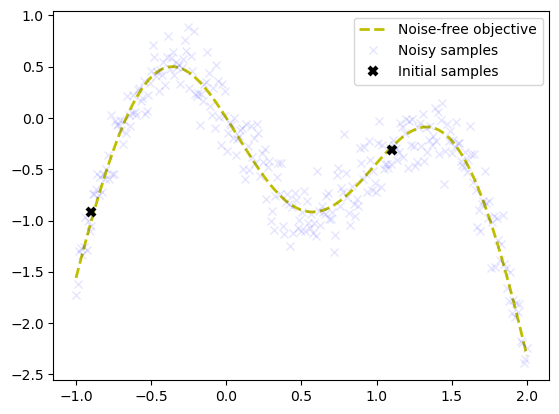

In [3]:
# Dense grid of points within bounds
np.random.seed(42)
X = np.linspace(bounds[0, 0], bounds[0, 1], 300).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X, 0)

# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'bx', lw=1, alpha=0.1, label='Noisy samples')
plt.plot(X_init, Y_init, 'kx', markeredgewidth=3, label='Initial samples')
plt.legend()
plt.show()

El objetivo, es encontrar el óptimo global a la izquierda, en una pequeña cantidad de pasos. 

El siguiente paso es implementar la función de adquisición definida en la ecuación (2) como función `expected_improvement`.

In [4]:
def expected_improvement(X, X_sample, Y_sample, gpr, xi=0.01):
    """
    Calcula la mejora esperada (Expected Improvement, EI) en los puntos X
    utilizando muestras X_sample, Y_sample y un modelo sustituto (Gaussian Process Regressor).

    Args:
        X (np.ndarray): Puntos donde calcular la EI (m x d).
        X_sample (np.ndarray): Ubicaciones de las muestras (n x d).
        Y_sample (np.ndarray): Valores de las muestras (n x 1).
        gpr (GaussianProcessRegressor): Modelo GP ajustado a las muestras.
        xi (float): Parámetro de exploración-explotación (default=0.01).

    Returns:
        np.ndarray: Valores de la función de adquisición EI en los puntos X.
    """
    # Predicción del modelo sustituto
    mu, sigma = gpr.predict(X, return_std=True)
    mu_sample = gpr.predict(X_sample)

    # Asegúrate de que sigma sea unidimensional
    sigma = sigma.flatten()

    # Valor máximo de la función objetivo conocido hasta ahora
    mu_sample_opt = np.max(mu_sample)

    # Calcula la EI
    with np.errstate(divide='warn'):
        imp = mu - mu_sample_opt - xi
        Z = np.divide(imp, sigma, where=(sigma != 0))  # Evita divisiones por cero
        ei = imp * norm.cdf(Z) + sigma * norm.pdf(Z)

    # Establece EI a 0 donde sigma es 0
    ei[sigma == 0] = 0.0

    return ei

También necesitamos una función que proponga el siguiente punto de muestreo, calculando la ubicación del máximo de la función de adquisición. La optimización se reinicia `n_restarts` veces para evitar óptimos locales.

In [5]:
def propose_location(acquisition, X_sample, Y_sample, gpr, bounds, n_restarts=25):
    """
    Propone el siguiente punto de muestreo optimizando la función de adquisición.

    Args:
        acquisition: Función de adquisición.
        X_sample: Ubicaciones de las muestras (n x d).
        Y_sample: Valores de las muestras (n x 1).
        gpr: GaussianProcessRegressor ajustado a las muestras.
        bounds: Límites del espacio de búsqueda (d x 2).
        n_restarts: Número de reinicios aleatorios para optimización global.

    Returns:
        np.ndarray: Ubicación del máximo de la función de adquisición.
    """
    dim = X_sample.shape[1]
    min_val = 1
    min_x = None

    def min_obj(X):
        # El objetivo de minimización es la función de adquisición negativa
        return -acquisition(X.reshape(-1, dim), X_sample, Y_sample, gpr).flatten()

    # Encuentra el mejor óptimo comenzando desde puntos aleatorios diferentes
    for x0 in np.random.uniform(bounds[:, 0], bounds[:, 1], size=(n_restarts, dim)):
        res = minimize(min_obj, x0=x0, bounds=bounds, method='L-BFGS-B')
        if res.fun < min_val:  # Aquí corregimos la comparación sin indexar res.fun
            min_val = res.fun
            min_x = res.x

    if min_x is None:
        raise ValueError("No se encontró un óptimo válido en propose_location.")

    return min_x.reshape(-1, 1)

Ahora tenemos todos los componentes necesarios para ejecutar la optimización bayesiana con el algoritmo descrito anteriormente. El proceso gaussiano del siguiente ejemplo está configurado con un [Matérn kernel](http://scikit-learn.org/stable/modules/gaussian_process.html#matern-kernel). El nivel de ruido conocido se configura con el parámetro `alpha`.

La optimización bayesiana, se ejecuta durante 10 iteraciones. En cada iteración, produce una fila con dos gráficos. 

El gráfico de la izquierda muestra la función objetivo sin ruido, la función sustituta, que es la media predictiva posterior de Gaussian Process, el intervalo de confianza  es de 95% de la media y las muestras ruidosas obtenidas de la función objetivo hasta el momento. 

El gráfico de la derecha muestra la función de adquisición. 

La línea discontinua vertical en ambos gráficos muestra el punto de muestreo propuesto para la siguiente iteración, que corresponde al máximo de la función de adquisición.

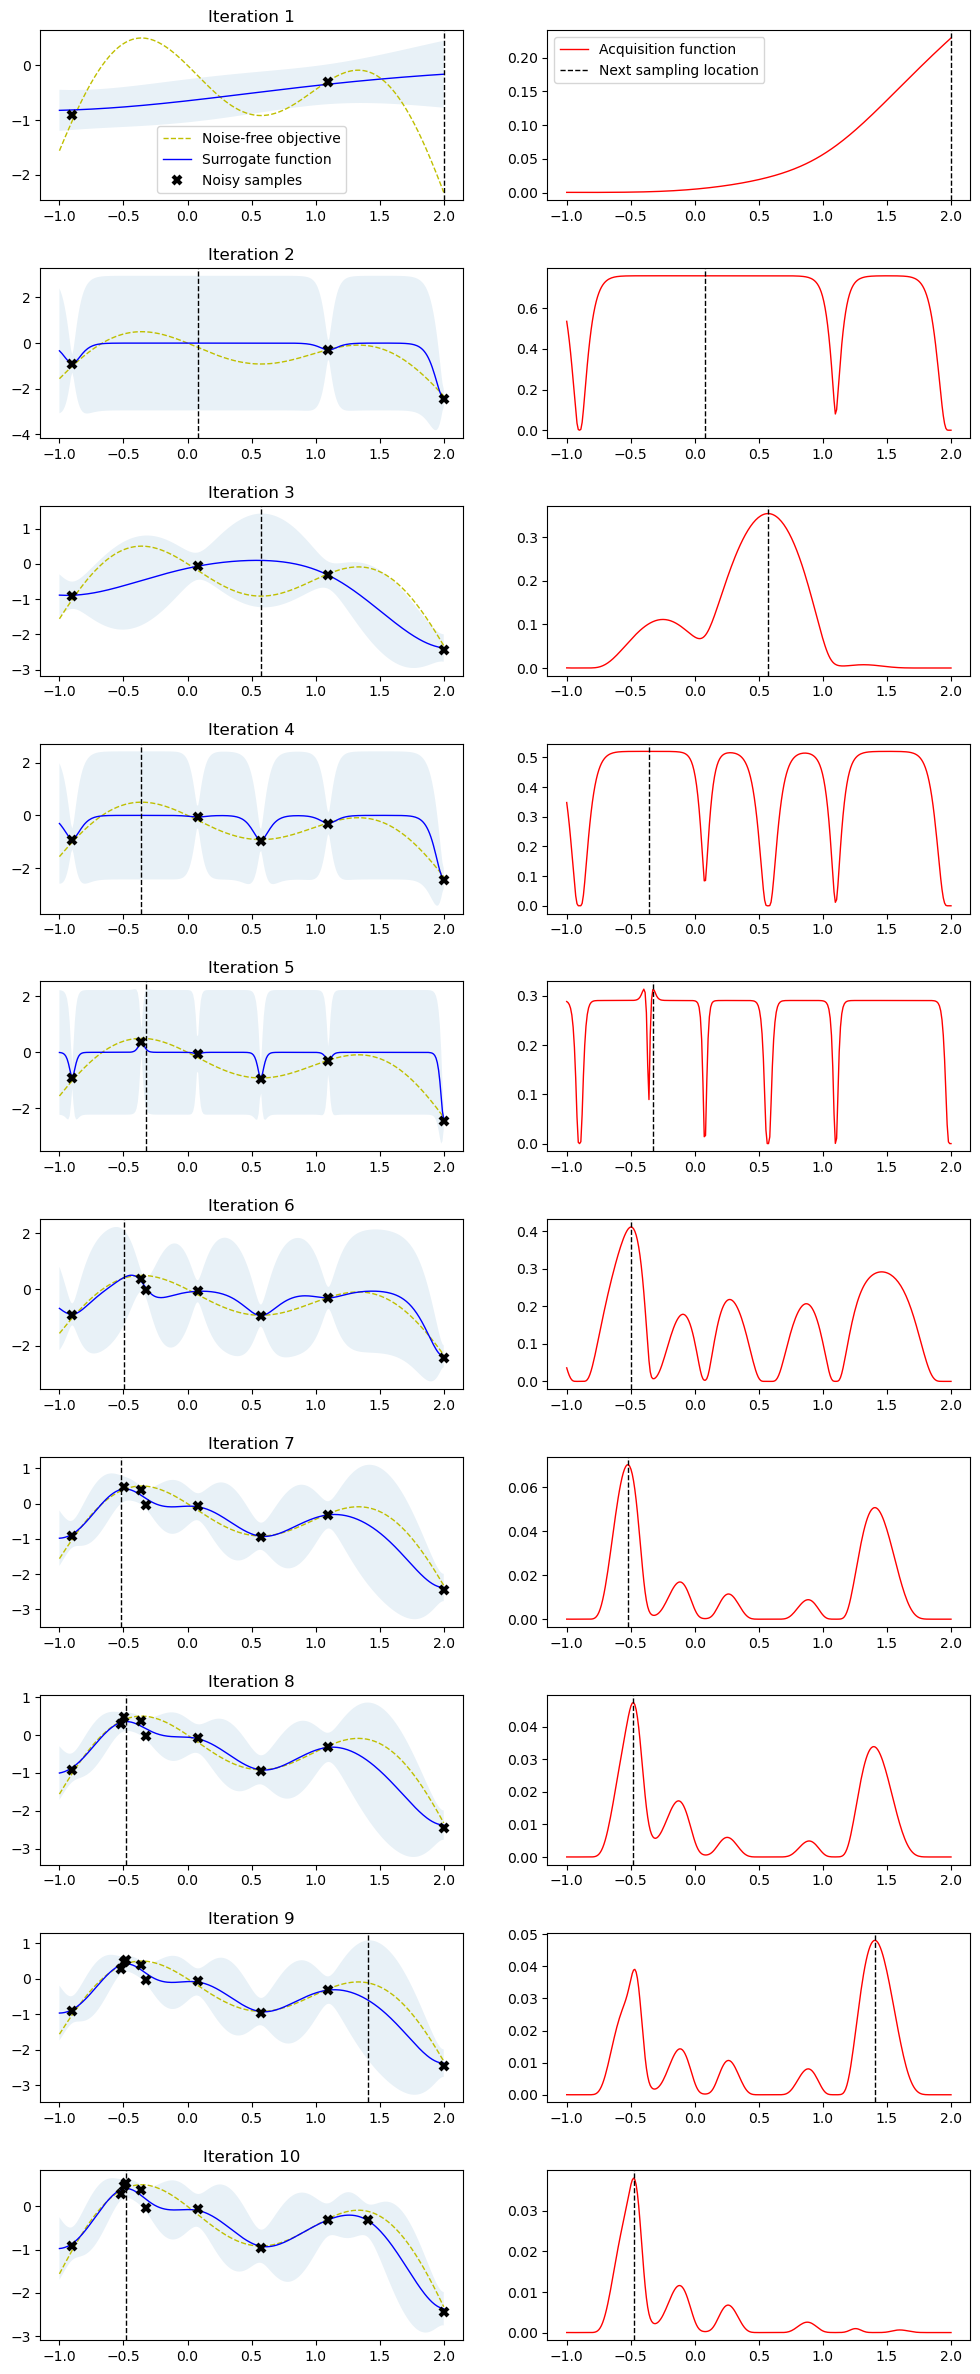

In [6]:
# Proceso gaussiano con kernel Matérn como modelo sustituto
np.random.seed(42)
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import ConstantKernel, Matern
from bayesian_optimization_util import plot_approximation, plot_acquisition

# Gaussian process with Matérn kernel as surrogate model
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Initialize samples
X_sample = X_init
Y_sample = Y_init

# Number of iterations
n_iter = 10

plt.figure(figsize=(12, n_iter * 3))
plt.subplots_adjust(hspace=0.4)

for i in range(n_iter):
    # Update Gaussian process with existing samples
    gpr.fit(X_sample, Y_sample)

    # Obtain next sampling point from the acquisition function (expected_improvement)
    X_next = propose_location(expected_improvement, X_sample, Y_sample, gpr, bounds)
    
    # Obtain next noisy sample from the objective function
    Y_next = f(X_next, noise)
    
    # Plot samples, surrogate function, noise-free objective and next sampling location
    plt.subplot(n_iter, 2, 2 * i + 1)
    plot_approximation(gpr, X, Y, X_sample, Y_sample, X_next, show_legend=i==0)
    plt.title(f'Iteration {i+1}')

    plt.subplot(n_iter, 2, 2 * i + 2)
    plot_acquisition(X, expected_improvement(X, X_sample, Y_sample, gpr), X_next, show_legend=i==0)
    
    # Add sample to previous samples
    X_sample = np.vstack((X_sample, X_next))
    Y_sample = np.vstack((Y_sample, Y_next))


Se puede observar, cómo las dos muestras iniciales dirigen la búsqueda hacia la dirección del máximo local en el lado derecho, pero la exploración, permite que el algoritmo escape de ese óptimo local y encuentre el óptimo global en el lado izquierdo. 

Así mismo se observa también cómo las propuestas de puntos de muestreo, a menudo caen dentro de regiones de alta incertidumbre (exploración) y no solo están impulsadas por los valores más altos de la función sustituta (explotación).

Un gráfico de convergencia revela cuántas iteraciones se necesitan para encontrar un máximo y si las propuestas de puntos de muestreo se mantienen alrededor de ese máximo, es decir, convergen a pequeñas diferencias entre pasos consecutivos.

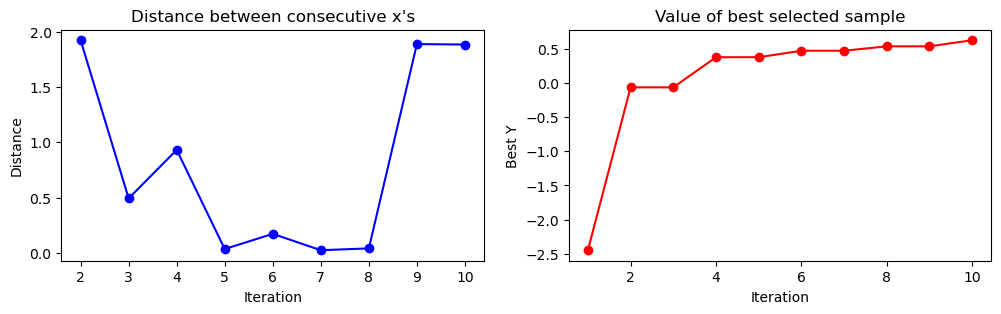

In [7]:
plot_convergence(X_sample, Y_sample)

## Bibliotecas de Optimización Bayesiana

Existen numerosas bibliotecas de optimización bayesiana y el objetivo de este análisis no es brindar una descripción general de dichas librerias, sino, de ejemplificar dos y mostrar la configuración mínima necesaria para ejecutar el ejemplo anterior.

### Scikit-optimize

[Scikit-optimize](https://scikit-optimize.github.io/) es una biblioteca para la optimización basada en modelos secuenciales que se basa en [NumPy](https://numpy.org/), [SciPy](https://scipy.org/) y [Scikit-Learn](http://scikit-learn.org/). También admite la optimización bayesiana mediante procesos gaussianos. La API está diseñada en torno a la minimización, por lo tanto, tenemos que proporcionar valores de función objetivo negativos. Los resultados obtenidos aquí difieren ligeramente de los resultados anteriores debido al comportamiento de optimización no determinista y a las diferentes muestras ruidosas extraídas de la función objetivo.

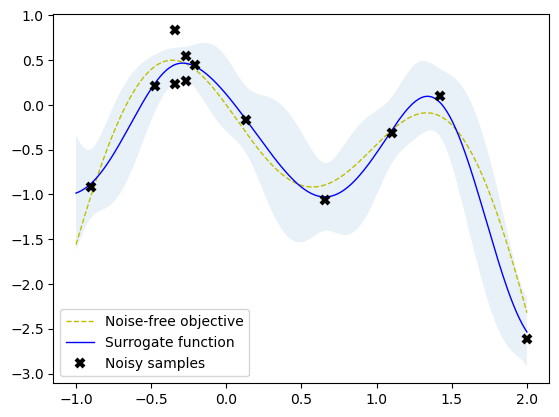

In [8]:
from sklearn.base import clone
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
from skopt.space import Real

# Define bounds as Real to avoid warnings
bounds = [Real(-1.0, 2.0)]

# Use custom kernel and estimator to match previous example
np.random.seed(42)
m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

# Perform Bayesian optimization
r = gp_minimize(lambda x: -f(np.array(x))[0], 
                bounds,               # Define bounds explicitly
                base_estimator=gpr,   # Use custom GP estimator
                acq_func='EI',        # Expected improvement
                xi=0.01,              # Exploitation-exploration trade-off
                n_calls=10,           # Number of iterations
                n_random_starts=0,    # Initial samples are provided
                x0=X_init.tolist(),   # Initial samples
                y0=-Y_init.ravel())   # Initial values

# Fit GP model to samples for plotting results
gpr.fit(r.x_iters, -r.func_vals)

# Plot the fitted model and the noisy samples
plot_approximation(gpr, X, Y, r.x_iters, -r.func_vals, show_legend=True)



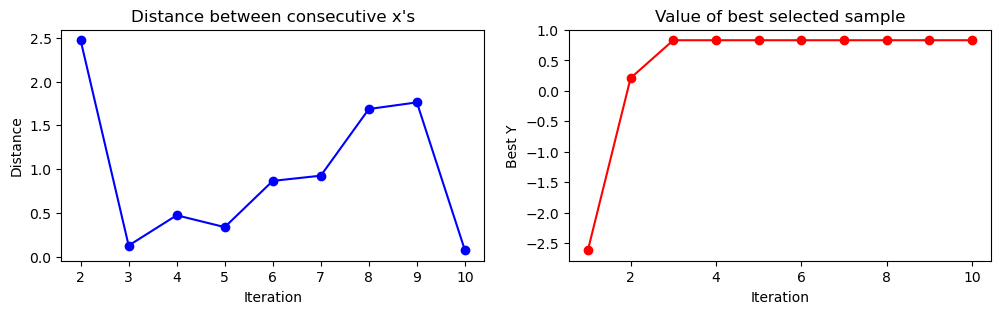

In [9]:
plot_convergence(np.array(r.x_iters), -r.func_vals)

## GPyOpt

[GPyOpt](http://sheffieldml.github.io/GPyOpt/) es una biblioteca de optimización bayesiana basada en [GPy](https://sheffieldml.github.io/GPy/). El nivel de abstracción de la API, es comparable al de scikit-optimize. 
La API `BayesianOptimization` proporciona un parámetro `maximize` para configurar si la función objetivo se maximizará o minimizará (predeterminado). En la versión 1.2.1, esto parece ignorarse al proporcionar muestras iniciales, por lo que tenemos que negar sus valores objetivo manualmente en el siguiente ejemplo. Además, los métodos integrados `plot_acquisition` y `plot_convergence` muestran el resultado de la minimización en cualquier caso. Nuevamente, los resultados obtenidos aquí difieren ligeramente de los resultados anteriores debido al comportamiento de optimización no determinista y a las diferentes muestras ruidosas extraídas de la función objetivo.

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Generar datos para la función de adquisición y el modelo
domain = bds[0]['domain']
x_grid = np.linspace(domain[0], domain[1], 100).reshape(-1, 1)
acquisition_function = optimizer.acquisition.acquisition_function
acq_values = acquisition_function(x_grid)

# Predicción del modelo
mu, sigma = optimizer.model.model.predict(x_grid)

# Crear la figura con subgráficas
fig, axs = plt.subplots(2, 1, figsize=(8, 6), gridspec_kw={'height_ratios': [3, 1]})

# Gráfica superior: Modelo Gaussiano y observaciones
axs[0].plot(x_grid, mu, 'k-', label="Predicted Mean")
axs[0].fill_between(x_grid.ravel(),
                    mu.ravel() - 1.96 * sigma.ravel(),
                    mu.ravel() + 1.96 * sigma.ravel(),
                    alpha=0.2, label="95% Confidence Interval")
axs[0].scatter(optimizer.X, optimizer.Y, color='red', label="Observed Points")
axs[0].set_title("Model Predictions and Observations")
axs[0].legend()

# Gráfica inferior: Función de adquisición
axs[1].plot(x_grid, acq_values, 'r-', label="Acquisition (arbitrary units)")
axs[1].axvline(x=optimizer.suggest_next_locations()[0][0], color='red', linestyle='--', label="Next Suggested Point")
axs[1].set_title("Acquisition Function")
axs[1].legend()

# Ajustar diseño y mostrar
plt.tight_layout()
plt.show()

NameError: name 'bds' is not defined

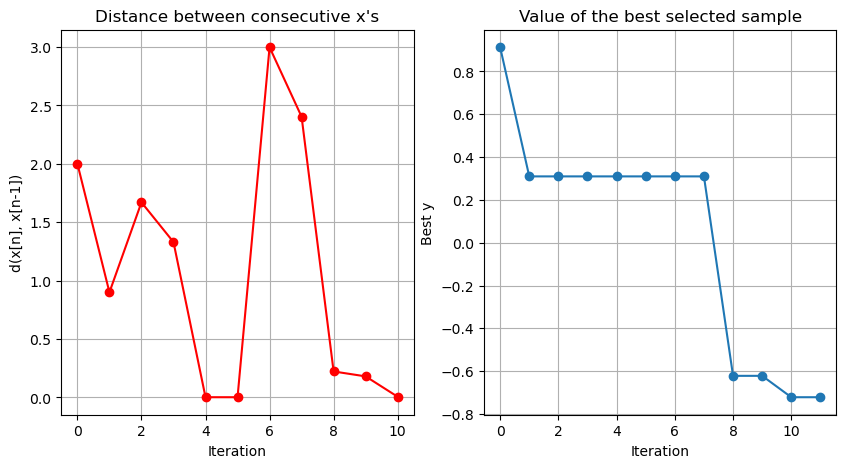

In [ ]:
optimizer.plot_convergence()

## Aplicación

En esta sección demostraremos cómo optimizar los hiperparámetros de un `XGBRegressor` con GPyOpt y cómo se compara el rendimiento de la optimización bayesiana con la búsqueda aleatoria. `XGBRegressor` es parte de [XGBoost](https://xgboost.readthedocs.io/), una biblioteca de aumento de gradiente flexible y escalable. `XGBRegressor` implementa la API de estimador de scikit-learn y se puede aplicar a problemas de regresión. La regresión se realiza en un pequeño [conjunto de datos de ejemplo](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_diabetes.html#sklearn.datasets.load_diabetes) que es parte de scikit-learn.

In [11]:
from sklearn import datasets
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

from scipy.stats import uniform
from xgboost import XGBRegressor

# Load the diabetes dataset (for regression)
X, Y = datasets.load_diabetes(return_X_y=True)

# Instantiate an XGBRegressor with default hyperparameter settings
xgb = XGBRegressor()

# and compute a baseline to beat with hyperparameter optimization 
baseline = cross_val_score(xgb, X, Y, scoring='neg_mean_squared_error').mean()

### Ajuste de hiperparámetros con búsqueda aleatoria

Para el ajuste de hiperparámetros con búsqueda aleatoria, utilizamos `RandomSearchCV` de scikit-learn y calculamos una puntuación de validación cruzada para cada punto seleccionado aleatoriamente en el espacio de hiperparámetros. Los resultados se analizarán a continuación:

In [12]:
# Hyperparameters to tune and their ranges
param_dist = {"learning_rate": uniform(0, 1),
              "gamma": uniform(0, 5),
              "max_depth": range(1,50),
              "n_estimators": range(1,300),
              "min_child_weight": range(1,10)}

rs = RandomizedSearchCV(xgb, param_distributions=param_dist, 
                        scoring='neg_mean_squared_error', n_iter=25)

# Run random search for 25 iterations
rs.fit(X, Y);

### Ajuste de hiperparámetros con optimización bayesiana

Para ajustar los hiperparámetros con optimización bayesiana, implementamos una función objetivo `cv_score` que toma los hiperparámetros como entrada y devuelve una puntuación de validación cruzada. Aquí, asumimos que la validación cruzada en un punto determinado en el espacio de hiperparámetros es determinista y, por lo tanto, establecemos el parámetro `exact_feval` de `BayesianOptimization` en `True`. Dependiendo del ajuste del modelo y los detalles de la validación cruzada, esto podría no ser el caso, pero lo ignoraremos aquí.

In [13]:
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}]

# Optimization objective 
def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
                XGBRegressor(learning_rate=parameters[0],
                              gamma=int(parameters[1]),
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              min_child_weight = parameters[4]), 
                X, Y, scoring='neg_mean_squared_error').mean()
    score = np.array(score)
    return score

optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.05,
                                 exact_feval=True, 
                                 maximize=True)

# Only 20 iterations because we have 5 initial random points
optimizer.run_optimization(max_iter=20)

In [14]:
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor
import numpy as np

# Define los dominios de búsqueda (bounds)
search_space = [
    Real(0, 1, name='learning_rate'),               # learning_rate
    Real(0, 5, name='gamma'),                       # gamma
    Integer(1, 50, name='max_depth'),               # max_depth
    Integer(1, 300, name='n_estimators'),           # n_estimators
    Integer(1, 10, name='min_child_weight')         # min_child_weight
]

# Función objetivo para minimizar (se negará el MSE para que sea una minimización)
@use_named_args(search_space)
def cv_score(learning_rate, gamma, max_depth, n_estimators, min_child_weight):
    model = XGBRegressor(
        learning_rate=learning_rate,
        gamma=gamma,
        max_depth=max_depth,
        n_estimators=n_estimators,
        min_child_weight=min_child_weight
    )
    score = cross_val_score(model, X, Y, scoring='neg_mean_squared_error').mean()
    return -score  # Negamos el puntaje para minimizar

# Ejecutar la optimización bayesiana
result = gp_minimize(
    func=cv_score,                 # Función objetivo
    dimensions=search_space,       # Espacio de búsqueda
    acq_func='EI',                 # Expected Improvement
    n_calls=20,                    # Número de iteraciones
    n_initial_points=5,            # Puntos iniciales aleatorios
    random_state=42                # Reproducibilidad
)

# Resultados de la optimización
print("Best parameters:")
print({dim.name: val for dim, val in zip(search_space, result.x)})
print("Best negative MSE:", result.fun)


Best parameters:
{'learning_rate': 0.4782211107113925, 'gamma': 5.0, 'max_depth': 1, 'n_estimators': 8, 'min_child_weight': 6}
Best negative MSE: 3411.6822568355324


### Resultados

En promedio, la optimización bayesiana encuentra un óptimo mejor en una menor cantidad de pasos que la búsqueda aleatoria y supera la línea base en casi todas las ejecuciones. Esta tendencia se vuelve aún más prominente en espacios de búsqueda de dimensiones superiores. Aquí, el espacio de búsqueda es de cinco dimensiones, lo cual es bastante bajo para obtener un beneficio sustancial de la optimización bayesiana. Una ventaja de la búsqueda aleatoria es que es fácil de paralelizar. La paralelización de la optimización bayesiana es mucho más difícil y está sujeta a investigación.

Baseline neg. MSE = 4000.18
Random search neg. MSE = -3763.63
Bayesian optimization skopt neg. MSE = -3411.68


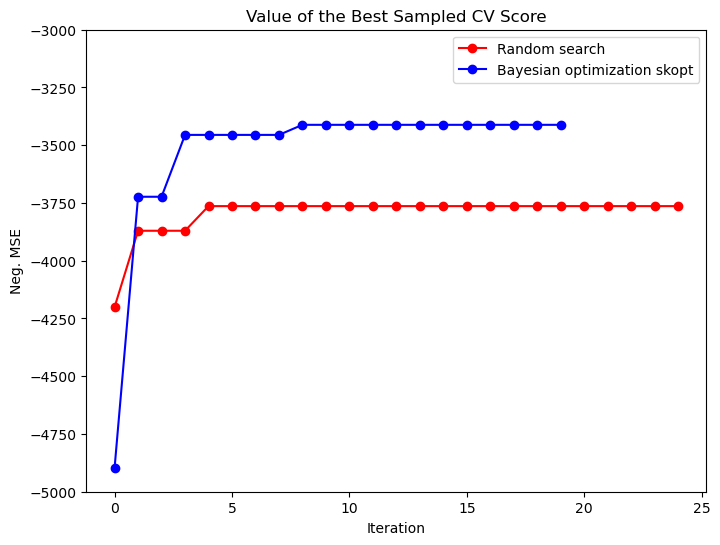

In [15]:
# Máximos acumulados para Random Search
# Asegúrate de que 'mean_test_score' esté disponible en tu búsqueda aleatoria
if 'mean_test_score' in rs.cv_results_:
    y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
else:
    y_rs = None

# Máximos acumulados para la optimización bayesiana
y_bo = np.maximum.accumulate(-np.array(result.func_vals))

# Imprimir los resultados
baseline = -np.mean(cross_val_score(XGBRegressor(), X, Y, scoring='neg_mean_squared_error'))
print(f'Baseline neg. MSE = {baseline:.2f}')
if y_rs is not None:
    print(f'Random search neg. MSE = {y_rs[-1]:.2f}')
print(f'Bayesian optimization skopt neg. MSE = {y_bo[-1]:.2f}')

# Graficar los resultados
plt.figure(figsize=(8, 6))
if y_rs is not None:
    plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization skopt')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-5000, -3000)  # Ajusta estos límites según tu problema
plt.title('Value of the Best Sampled CV Score')
plt.legend()
plt.show()


Baseline neg. MSE = 4000.18
Random search neg. MSE = -3763.63
Bayesian optimization GPyOpt neg. MSE = -3184.27


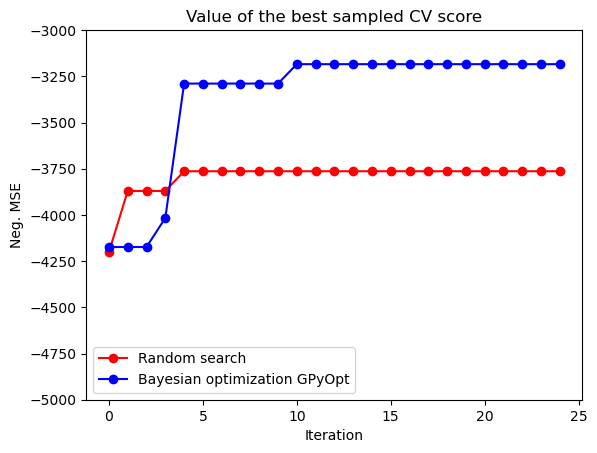

In [16]:
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

print(f'Baseline neg. MSE = {baseline:.2f}')
print(f'Random search neg. MSE = {y_rs[-1]:.2f}')
print(f'Bayesian optimization GPyOpt neg. MSE = {y_bo[-1]:.2f}')

plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization GPyOpt')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.ylim(-5000, -3000)
plt.title('Value of the best sampled CV score');
plt.legend();

-----

### California Housing Prices

In [17]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from scipy.stats import uniform
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

# Cargar el dataset de California Housing Prices
data = fetch_california_housing()
X, Y = data.data, data.target  # X: características, Y: precios de vivienda


In [18]:
# Crear un modelo base de XGBoost
xgb = XGBRegressor()

# Evaluar el modelo base utilizando validación cruzada
baseline = -cross_val_score(xgb, X, Y, scoring='neg_mean_squared_error').mean()
print(f'Baseline neg. MSE = {baseline:.2f}')


Baseline neg. MSE = 0.44


In [19]:
# Definir los hiperparámetros y sus rangos
param_dist = {
    "learning_rate": uniform(0, 1),       # Tasa de aprendizaje
    "gamma": uniform(0, 5),              # Regularización gamma
    "max_depth": range(1, 50),           # Profundidad máxima de los árboles
    "n_estimators": range(1, 300),       # Número de árboles
    "min_child_weight": range(1, 10)     # Peso mínimo por nodo
}

# RandomizedSearchCV con 25 iteraciones
rs = RandomizedSearchCV(
    xgb,
    param_distributions=param_dist,
    scoring='neg_mean_squared_error',
    n_iter=25,
    random_state=42
)
rs.fit(X, Y)


RandomizedSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=None,...
                                          random_state=None, ...),
                   n_iter=25,
                   param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x174e38e60>,
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x175f5e3f0>,
                                        'max_depth': range(1, 50),
                                        'min_child_weight': range(1, 10),
                                        'n_estimators': range(1, 300)},
                   random_state=42, scoring='neg_mean_squared_error')

In [28]:
from GPyOpt.methods import BayesianOptimization

# Definir los límites del dominio
bds = [
    {'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
    {'name': 'gamma', 'type': 'continuous', 'domain': (0, 5)},
    {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 50)},
    {'name': 'n_estimators', 'type': 'discrete', 'domain': (1, 300)},
    {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}
]

# Definir la función objetivo
def cv_score(parameters):
    parameters = parameters[0]
    model = XGBRegressor(
        learning_rate=parameters[0],
        gamma=parameters[1],
        max_depth=int(parameters[2]),
        n_estimators=int(parameters[3]),
        min_child_weight=int(parameters[4])
    )
    score = -cross_val_score(model, X, Y, scoring='neg_mean_squared_error').mean()
    return score

# Configurar la optimización bayesiana
optimizer = BayesianOptimization(
    f=cv_score,
    domain=bds,
    model_type='GP',  # Usamos un modelo de Gaussian Process
    acquisition_type='EI',  # Expected Improvement
    maximize=False,  # Minimizar el MSE negativo
)


# Ejecutar la optimización
optimizer.run_optimization(max_iter=20)


Baseline neg. MSE = 0.44
Random search neg. MSE = -0.38
Bayesian optimization GPyOpt neg. MSE = -0.47


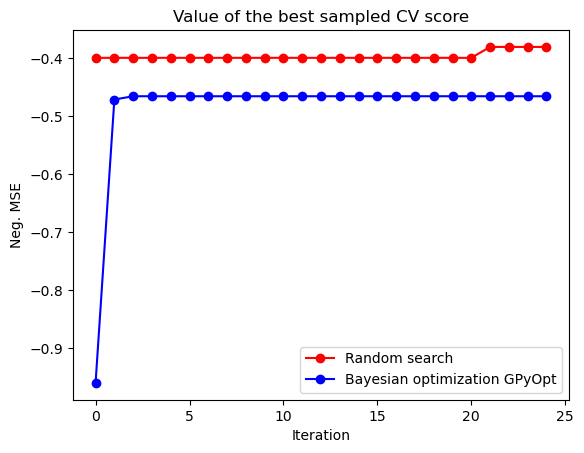

In [29]:
# Comparar resultados de Random Search y Bayesian Optimization
y_rs = np.maximum.accumulate(rs.cv_results_['mean_test_score'])
y_bo = np.maximum.accumulate(-optimizer.Y).ravel()

print(f'Baseline neg. MSE = {baseline:.2f}')
print(f'Random search neg. MSE = {y_rs[-1]:.2f}')
print(f'Bayesian optimization GPyOpt neg. MSE = {y_bo[-1]:.2f}')

# Graficar
plt.plot(y_rs, 'ro-', label='Random search')
plt.plot(y_bo, 'bo-', label='Bayesian optimization GPyOpt')
plt.xlabel('Iteration')
plt.ylabel('Neg. MSE')
plt.title('Value of the best sampled CV score')
plt.legend()
plt.show()


## Referencias
[1] Hyunghun Cho et al.: *Basic Enhancement Strategies When Using Bayesian Optimization for Hyperparameter Tuning of Deep Neural Networks*, Special section on scalable deeo learning for big data, VOLUME 8, Digital Object Identifier 10.1109/ACCESS.2020.2981072, pp. 52588-52608 IEEE Access, 2020

[2] James Bergstra et al: *Algorithms for Hyper-Parameter Optimization*, NIPS'11: Proceedings of the 24th International Conference on Neural Information Processing Systems,  pp. 2546 - 2554, 2011

[3] Jia Wu et al: *Hyperparameter Optimization for Machine Learning Models Based on Bayesian Optimization*, Journal of Electronic Science , VOL. 17, NO. 1,Digital Object Identifier:10.11989/JEST.1674-862X.80904120, pp.26 - 40, 2019, 